In [354]:
import hashlib
import os
import tarfile
import zipfile
import requests

# 二元组（数据url，sha-1密钥）
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'


# 下载和缓存数据集

In [355]:
def download(name, cache_dir=os.path.join('..','data')):
  """下载一共DATA_HUB中的文件，返回本地文件名"""
  assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
  url, sha1_hash = DATA_HUB[name]
  os.makedirs(cache_dir, exist_ok=True)
  fname = os.path.join(cache_dir, url.split('/')[-1])
  if os.path.exists(fname):
    sha1 = hashlib.sha1()
    with open(fname, 'rb') as f :
      while True:
        data = f.read(1048576)
        if not data:
          break
        sha1.update(data)
    if sha1.hexdigest() == sha1_hash:
      return fname #命中缓存
  print(f'正在从{url}下载{fname}...')
  r = requests.get(url, stream=True, verify=True)
  with open(fname, 'wb') as f:
    f.write(r.content)
  return fname

In [356]:
def download_extract(name, folder=None):
  """下载并解压zip/tar文件"""
  fname = download(name)
  base_dir = os.path.dirname(fname)
  data_dir, ext = os.path.splitext(fname)
  if ext == '.zip':
    fp = zipfile.ZipFile(fname, 'r')
  elif ext in ('.tar', '.gz'):
    fp = tarfile.open(fname, 'r')
  else:
    assert False
  fp.extractall(base_dir)
  return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
  for name in DATA_HUB:
    download(name)

# 访问和读取数据集

In [357]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils import data

In [358]:
DATA_HUB['kaggle_house_train'] = ( DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = ( DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [359]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [360]:

print(train_data.shape)
print(test_data.shape)
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])

(1460, 81)
(1459, 80)
   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [361]:
#删除id列
all_features = pd.concat((train_data.iloc[:,1:-1], test_data.iloc[:,1:]))

In [362]:
print(len(all_features.columns))

79


# 数据预处理

1. 缺失值处理为相应特征的平均值
2. 特征重新缩放到零均值和单位方差
$$x⬅\frac{x-μ}{σ}$$

In [363]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [364]:

# 若无法获得测试数据，可以用训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
  lambda x: (x-x.mean()) / (x.std())
)
# 在标准化数据后，所有均值消失，可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)


In [365]:
all_features

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,0.067320,RL,-0.184443,-0.217841,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,0.157619,WD,Normal
1,-0.873466,RL,0.458096,-0.072032,Pave,NaN,Reg,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.446848,-0.602858,WD,Normal
2,0.067320,RL,-0.055935,0.137173,Pave,NaN,IR1,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,0.157619,WD,Normal
3,0.302516,RL,-0.398622,-0.078371,Pave,NaN,IR1,Lvl,AllPub,Corner,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-1.551918,-1.363335,WD,Abnorml
4,0.067320,RL,0.629439,0.518814,Pave,NaN,IR1,Lvl,AllPub,FR2,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,2.131647,0.157619,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.419286,RM,-2.069222,-1.043758,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.078492,-1.363335,WD,Normal
1455,2.419286,RM,-2.069222,-1.049083,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,-0.815205,-1.363335,WD,Abnorml
1456,-0.873466,RL,3.884968,1.246594,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,NaN,NaN,-0.089577,1.026577,-1.363335,WD,Abnorml
1457,0.655311,RL,-0.312950,0.034599,Pave,NaN,Reg,Lvl,AllPub,Inside,...,-0.285886,-0.063139,NaN,MnPrv,Shed,1.144116,0.289865,-1.363335,WD,Normal


In [366]:
#对于离散值,自动拆成独热编码,比如一个特征M包含RL,RM两种值,那么就拆成特征M_RL和M_RM
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [367]:
# 转化成张量
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
  train_data.SalePrice.values.reshape(-1,1), dtype=torch.float32
)

# 训练

## baseline模型
线性模型将作为baseline model,帮助我们查看数据中是否存在有意义的信息

In [368]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
  net = nn.Sequential(nn.Linear(in_features,1))
  return net

房价和股票价格一样,只关心相对数量,即相对误差$\frac{y-\hat{y}}{y}$,官方的误差指标是:
$$\sqrt{\frac{1}{n}\sum_{i=1}^n\left(\log y_i -\log \hat{y}_i\right)^2}.$$



In [369]:
def log_rmse(net, features, labels):
  # 为了在取对数的时候进一步稳定该值,将小于1的值设置为1
  clipped_preds = torch.clamp(net(features),1,float('inf'))
  rmse = torch.sqrt(loss(torch.log(clipped_preds),
                         torch.log(labels)))
  return rmse.item()

In [370]:
def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

In [371]:
def train(net, train_features, train_labels, test_features, test_labels, num_epochs, lr, weight_decay, batch_size):
  train_ls, test_ls = [], []
  train_iter = load_array((train_features, train_labels), batch_size)
  #Adam优化算法
  optimizer = torch.optim.Adam(net.parameters(),
                               lr = lr,
                               weight_decay = weight_decay)
  
  for epoch in range(num_epochs):
    for X,y in train_iter:
      optimizer.zero_grad()
      l = loss(net(X),y)
      l.backward()
      optimizer.step()
    train_ls.append(log_rmse(net, train_features, train_labels))
    if test_labels is not None:
      test_ls.append(log_rmse(net, test_features, test_labels))
  return train_ls, test_ls
  

## K折交叉验证

In [372]:
def get_k_fold_data(k,i,X,y):
  assert k > 1
  fold_size = X.shape[0] // k
  X_train, y_train = None ,None
  for j in range(k):
    idx = slice(j * fold_size, (j+1) * fold_size)
    X_part, y_part = X[idx, :], y[idx]
    if j == i:
      X_valid, y_valid = X_part, y_part
    elif X_train is None:
      X_train, y_train = X_part, y_part
    else:
      X_train = torch.cat([X_train,X_part],0)
      y_train = torch.cat([y_train,y_part],0)
  return X_train, y_train, X_valid, y_valid

In [373]:
import matplotlib.pyplot as plt
def k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size):
  fig, ax = plt.subplots()
  ax.set_xlabel('epoch')
  ax.set_ylabel('rmse')
  ax.set_yscale('log')
  ax.set_xlim([1, num_epochs])
  train_l_sum, valid_l_sum = 0,0
  for i in range(k):
    data = get_k_fold_data(k,i,X_train,y_train)
    net = get_net()
    train_ls, valid_ls = train(net, *data, num_epochs, lr, weight_decay, batch_size)
    train_l_sum += train_ls[-1]
    valid_l_sum += valid_ls[-1]
    if i == 0:
      ax.plot(list(range(1, num_epochs + 1)), train_ls, label='train')
      ax.plot(list(range(1, num_epochs + 1)), valid_ls, label='valid')
      ax.legend()
      plt.show()
    print(f'折{i + 1}，训练log rmse:{float(train_ls[-1]):f}, '
              f'验证log rmse:{float(valid_ls[-1]):f}')
  return train_l_sum / k, valid_l_sum / k

[3.55255126953125, 2.8662302494049072, 2.4694340229034424, 2.1897058486938477, 1.975011944770813, 1.8015679121017456, 1.6552793979644775, 1.5308265686035156, 1.422347903251648, 1.3260447978973389, 1.2398631572723389, 1.1618098020553589, 1.0910617113113403, 1.0264896154403687, 0.9674080610275269, 0.9123020768165588, 0.8617761135101318, 0.8149741291999817, 0.7710334062576294, 0.7300151586532593, 0.6920008063316345, 0.6563502550125122, 0.6229700446128845, 0.5911656618118286, 0.5618570446968079, 0.5339987874031067, 0.5080175399780273, 0.4832336902618408, 0.4601234793663025, 0.43857672810554504, 0.41817566752433777, 0.39883431792259216, 0.3807836174964905, 0.3640311658382416, 0.34814557433128357, 0.3333207368850708, 0.3195619285106659, 0.30639538168907166, 0.2943476438522339, 0.28313905000686646, 0.27268561720848083, 0.26280477643013, 0.2540016174316406, 0.24558745324611664, 0.23791301250457764, 0.23084811866283417, 0.22444482147693634, 0.2185865342617035, 0.21309497952461243, 0.20835959911

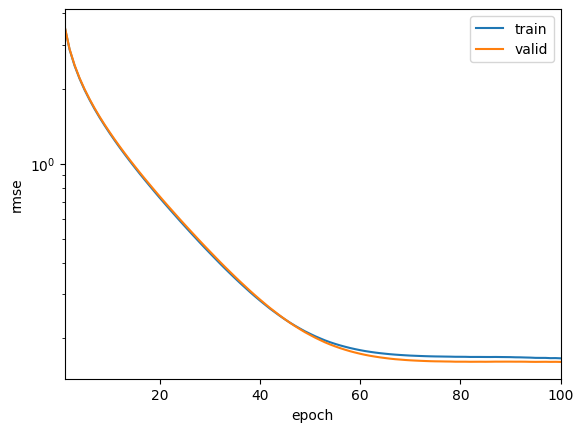

折1，训练log rmse:0.166206, 验证log rmse:0.160764
折2，训练log rmse:0.167095, 验证log rmse:0.152745
折3，训练log rmse:0.153588, 验证log rmse:0.218087
折4，训练log rmse:0.165230, 验证log rmse:0.135443
折5，训练log rmse:0.161225, 验证log rmse:0.163603
折6，训练log rmse:0.167229, 验证log rmse:0.181088
6-折验证: 平均训练log rmse: 0.163429, 平均验证log rmse: 0.168622


In [374]:
k , num_epochs, lr, weight_decay , batch_size = 6, 100, 6, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 提交Kaggle预测

In [375]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
  net = get_net()
  train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
  fig, ax = plt.subplots()
  ax.set_xlabel('epoch')
  ax.set_xlim([1, num_epochs])
  ax.set_ylabel('log rmse')
  ax.set_yscale('log')
  ax.plot(list(range(1, num_epochs + 1)), train_ls, label='train')
  ax.legend()
  plt.show()
  print(f'训练log rmse: {float(train_ls[-1]):f}')
  #将网络应用于测试集
  preds = net(test_features).detach().numpy()
  #导出到Kaggle
  test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
  submission = pd.concat([test_data['Id'], test_data['SalePrice']],axis=1)
  submission.to_csv('submission.csv',index=False)
  

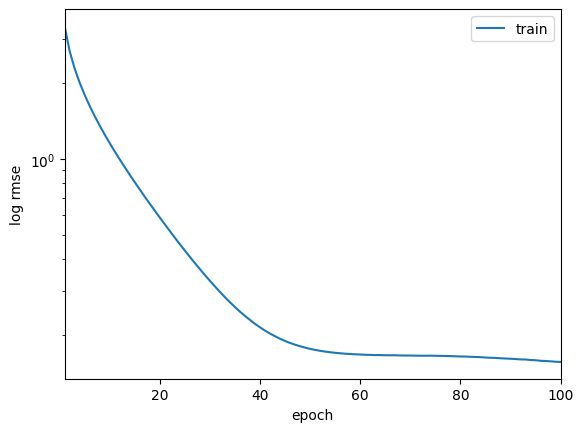

训练log rmse: 0.156569


In [376]:
train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr,weight_decay,batch_size)

# 神经网络模型

In [381]:
torch.cuda.set_device(0)
loss = nn.MSELoss()
in_features = train_features.shape[1]
def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)
    
def get_net():
  net = nn.Sequential(nn.Linear(in_features,32),
                      nn.ReLU(),
                      nn.Linear(32,1),
                      )
  net.apply(init_weights)
  return net


[0.2507695257663727, 0.16610151529312134, 0.18237578868865967, 0.17526845633983612, 0.13135123252868652, 0.14563217759132385, 0.12620359659194946, 0.12438882887363434, 0.12917278707027435, 0.14153501391410828, 0.1167880967259407, 0.10631851106882095, 0.14723911881446838, 0.11386340111494064, 0.16241952776908875, 0.11873378604650497, 0.10377483814954758, 0.11022341996431351, 0.1073445975780487, 0.12360690534114838, 0.09688759595155716, 0.10987341403961182, 0.09766007214784622, 0.10605604201555252, 0.09218818694353104, 0.09576275199651718, 0.09557914733886719, 0.1126166358590126, 0.09880054742097855, 0.09942040592432022, 0.11552190780639648, 0.11488649249076843, 0.10547297447919846, 0.08569010347127914, 0.09535765647888184, 0.11068534106016159, 0.11975471675395966, 0.09896205365657806, 0.11504266411066055, 0.08860977739095688, 0.08213280141353607, 0.09126100689172745, 0.09564466029405594, 0.08791884779930115, 0.09256843477487564, 0.09126921743154526, 0.08746032416820526, 0.07631255686283

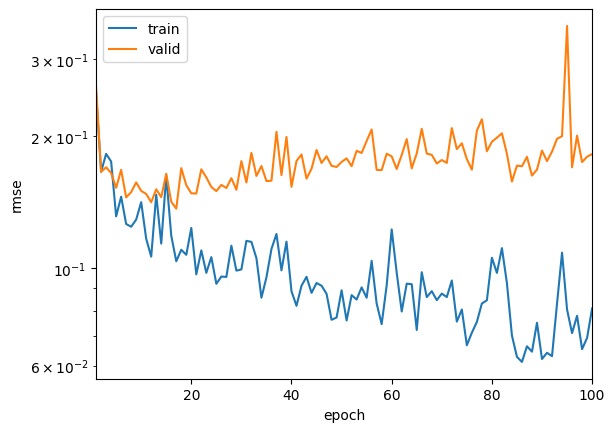

折1，训练log rmse:0.081002, 验证log rmse:0.182143
折2，训练log rmse:0.070122, 验证log rmse:0.154076
折3，训练log rmse:0.063840, 验证log rmse:0.178780
折4，训练log rmse:0.129758, 验证log rmse:0.175276
折5，训练log rmse:0.098969, 验证log rmse:0.150792
折6，训练log rmse:0.108353, 验证log rmse:0.205765
6-折验证: 平均训练log rmse: 0.092007, 平均验证log rmse: 0.174472


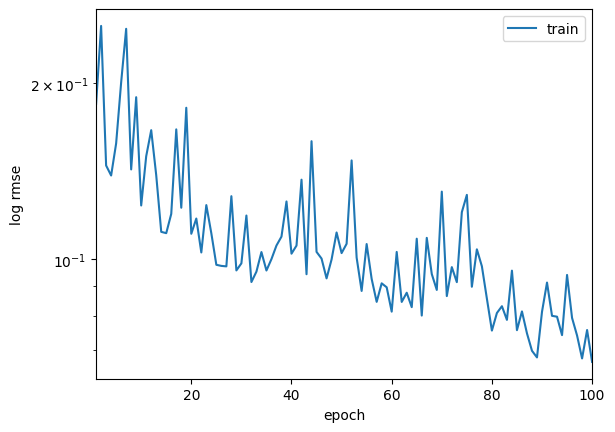

训练log rmse: 0.066849


In [382]:
k , num_epochs, lr, weight_decay , batch_size = 6, 100, 6, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr, weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr,weight_decay,batch_size)